## Collaborative Filtering approach

Below are CF based approaches for music recommendation and analysis of RMSE for each.

In [8]:
# import dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from collections import defaultdict

In [9]:
user_data_df = pd.read_csv('./output_plays_small_preprocessed.csv')
user_data_df.columns = ['userID', 'songID', 'playCount']

In [43]:
song_df =  pd.read_csv('./output.csv')


In [11]:
dataset = Dataset.load_from_df(user_data_df, Reader(rating_scale=(0, 5)))
trainset, testset = train_test_split(dataset, test_size=0.25)

In [12]:
svd = SVD()
svd_rmse = np.mean(cross_validate(svd, dataset, measures=['RMSE'], cv=5)['test_rmse'])
svd_rmse

0.37634661827066906

In [13]:
knn = KNNBasic(k=5, sim_options={'name': 'cosine','user_based': True})
knn_rmse = np.mean(cross_validate(knn, dataset, measures=['RMSE'], cv=5)['test_rmse'])
knn_rmse

Computing the cosine similarity matrix...


/Users/sava/miniforge3/envs/test/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


0.4189944841703358

In [14]:
cc = CoClustering()
cc_rmse = np.mean(cross_validate(cc, dataset, measures=['RMSE'], cv=5)['test_rmse'])
cc_rmse

0.43339897080818657

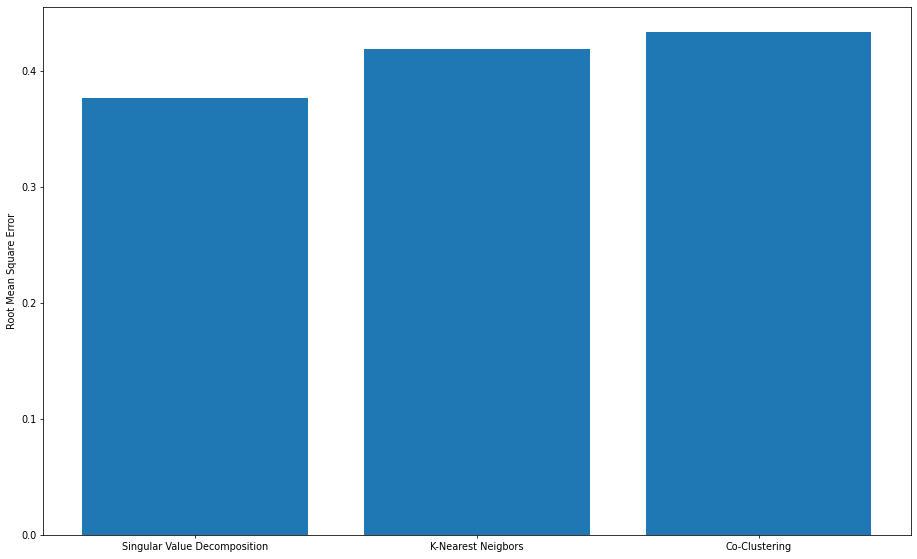

In [17]:
fig=plt.figure(figsize=(16, 10), dpi= 70, facecolor='w', edgecolor='k')
plt.bar([0,1,2], [svd_rmse, knn_rmse, cc_rmse])
plt.xticks([0,1,2], ('Singular Value Decomposition', 'K-Nearest Neigbors', 'Co-Clustering'))
plt.ylabel('Root Mean Square Error')
plt.show()

## Testing algorithm on a user

Returning top 10 recommendations for a single user.

In [18]:
def get_top_n(user_id, predictions, n=10):
    # Map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if uid == user_id:
            top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [45]:
song_df.shape
song_df.head()

,artist_name,title,artist_location,release,hotttness,familiarity,danceability,duration,energy,loudness,...,analysis_rate,end_of_fade_in,key,key_confidence,mode,mode_confidence,start_of_fade_out,time_signature,time_signature_conf,song_id
0,Baka Beyond,Journey Album Version,Cameroon,The Meeting Pool,0.391484,0.559823,0.0,368.14322,0.0,-11.482,...,22050,0.000,9,0.588,0,0.367,358.905,4,0.000,SOXFJZQ12A6D4F81FB
1,The Fleetwoods,Ten Times Blue,Olympia WA,Come Softly To Me The Very Best Of The Fleetwoods,0.397711,0.503821,0.0,175.59465,0.0,-15.193,...,22050,0.374,5,0.595,1,0.519,160.142,4,0.769,SOMSPXD12A8C139F36
2,Joe Satriani,Its So Good,Westbury Long Island NY,Super Colossal,0.620948,0.705876,0.0,254.85016,0.0,-4.707,...,22050,0.113,7,0.100,1,0.393,238.939,4,0.895,SOSIYAD12A8C14097F
3,LANDA DANIEL,A KDO TEDA VODDELAL TOHO FANDU,NaN,Konec,0.000000,0.013031,0.0,162.21995,0.0,-13.007,...,22050,0.287,9,0.591,0,0.671,154.273,1,0.147,SOHPHTP12A8C13BF53
4,Nickodemus,Endangered Species,New York NY,Turntables On The Hudson Lunar New Year 4707,0.372731,0.573806,0.0,276.53179,0.0,-8.107,...,22050,4.963,3,0.170,0,0.031,263.622,5,0.278,SOHXIRQ12AAA15CF81


In [63]:
import random

predictions_svd = svd.test(testset)
# user_id = random.sample(set(user_data_df['userID'].unique()),1)[0]
user_id = '1f93e135c4c4ca9b6f1509614c2cdd8a32b54fc8'

top_n = get_top_n(user_id, predictions_svd, n=3)

recommendations = pd.DataFrame(columns=['title', 'artist', 'year'])
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    for rating in user_ratings:
        song_id = rating[0]
        if song_df[song_df['song_id'] == song_id].empty:
            continue
        song_title = song_df[song_df['song_id'] == song_id]['title'].to_string().split('    ')[1]
        artist = song_df[song_df['song_id'] == song_id]['artist_name'].to_string().split('    ')[1]
        year = song_df[song_df['song_id'] == song_id]['year'].to_string().split('    ')[1]
        recommendations = recommendations.append({'title': song_title, 'artist': artist, 'year': year}, ignore_index=True)

recommendations

,title,artist,year
0,Walking On The Moon,The Police,1979
1,No Pasará Lo Mismo,Rafael Orozco Con El Binomio De Oro,0
2,Las flores,Café Tacvba,1994
